<a href="https://colab.research.google.com/github/KMVarma/828i_f20/blob/main/Loading_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive for access to src folder and data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tensorflow_io

     |████████████████████████████████| 22.4MB 1.4MB/s 


In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import itertools
from math import inf
import numpy as np
import tensorflow_io as tfio
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from os import listdir
from imageio import imread

In [25]:
from drive.MyDrive.src.models import get_pretrained_model
from drive.MyDrive.src.utils import preprocessed_rgb_to_ycbcr, preprocessed_ycbcr_to_rgb, ypbpr_to_rgb, imshow
from drive.MyDrive.src.plot import plot_image_with_inference
from drive.MyDrive.src.attack import *

In [27]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    image = preprocessed_rgb_to_ycbcr(image)
    return image

In [28]:
# MobileNet was trained on ImageNet (ILSVRC 2012) and specifying include_top=True means input images need static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
pretrained_model, decode_predictions = get_pretrained_model('MobileNetV2', 'imagenet')

def predict(im):
    return pretrained_model.predict(preprocessed_ycbcr_to_rgb(im))

In [15]:
# 5,000 ILSVRC 2010 (ImageNet) validation images
# only 4,901 are loaded correctly for some reason
# indices of those that can't be loaded: [9, 14, 48, 82, 182, 224, 361, 398, 403, 457, 484, 514, 520, 594, 638, 743, 744, 875, 904, 966, 972, 1038, 1136, 1262, 1288, 1310, 1345, 1380, 1432, 1495, 1594, 1618, 1690, 1815, 1872, 1882, 1954, 1982, 1997, 2030, 2051, 2114, 2273, 2335, 2429, 2490, 2494, 2509, 2653, 2666, 2673, 2722, 2737, 2878, 2880, 2912, 3008, 3023, 3038, 3099, 3124, 3149, 3164, 3209, 3266, 3269, 3276, 3281, 3296, 3404, 3418, 3432, 3525, 3651, 3755, 3757, 3890, 3962, 4049, 4052, 4269, 4271, 4282, 4301, 4332, 4406, 4412, 4430, 4468, 4476, 4620, 4639, 4650, 4688, 4758, 4812, 4891, 4902, 4903]
image_directory = 'drive/MyDrive/valid-5k/'
label_path = 'drive/MyDrive/ILSVRC2012_validation_ground_truth.txt'
label_file = open(label_path)
lines = label_file.readlines()
imagenet_y = []
for i, image in enumerate(listdir(image_directory)):
  if 'JPEG' in image:
    unprocessed = imread(image_directory + image)
    if len(np.shape(unprocessed)) != 3:
      print("problem loading image ", i)
    else:
      processed_im = preprocess(unprocessed)
      if i == 0:
        imagenet_x = processed_im
      else:
        imagenet_x = tf.concat([imagenet_x, processed_im], 0)
      imagenet_y.append(int(lines[i]))
np.shape(imagenet_x)

problem loading image  9
problem loading image  14
problem loading image  48
problem loading image  82
problem loading image  182
problem loading image  224
problem loading image  361
problem loading image  398
problem loading image  403
problem loading image  457
problem loading image  484
problem loading image  514
problem loading image  520
problem loading image  594
problem loading image  638
problem loading image  743
problem loading image  744
problem loading image  875
problem loading image  904
problem loading image  966
problem loading image  972
problem loading image  1038
problem loading image  1136
problem loading image  1262
problem loading image  1288
problem loading image  1310
problem loading image  1345
problem loading image  1380
problem loading image  1432
problem loading image  1495
problem loading image  1594
problem loading image  1618
problem loading image  1690
problem loading image  1815
problem loading image  1872
problem loading image  1882
problem loading im

TensorShape([4901, 224, 224, 3])

imhat_y is [[444.103333 -166.354141 98.5009613 -54.8428421 50.4917603 -18.8666573 23.0851212 3.34018517]
 [-135.096039 34.8306389 -31.6226578 11.900444 -16.9048042 1.26569748 -8.64153194 -3.83581448]
 [95.7867737 -36.8331261 23.5908203 -10.1439877 13.3218498 -0.672938347 8.4168129 4.62539244]
 [-40.6831932 5.68691206 -9.8262682 0.992004395 -6.94409895 -1.64747429 -4.94196463 -3.0422821]
 [43.2675705 -28.1891365 7.50703239 -11.0830631 1.5150013 -6.95737362 -2.2365365 -3.92196822]
 [-14.864852 -7.80482864 -5.71635723 -4.51918602 -5.2845192 -5.1225996 -4.89831257 -3.87213826]
 [26.9635582 -16.1536751 5.60967922 -6.3478384 1.50038815 -3.62357426 -0.624040604 -1.22919726]
 [9.87148476 -10.6169453 1.52036285 -4.25233459 0.473644257 -1.65058517 -1.01325607 -1.28524971]]
imhat_y shape is  (224, 224)
imhat_y min is  tf.Tensor(-749.46716, shape=(), dtype=float32)
imhat_y max is  tf.Tensor(663.26825, shape=(), dtype=float32)
stacked shape (1, 224, 224, 3)
imhat_y is [[172.975433 -38.3853531 35.87

/content/drive/MyDrive/src/attack.py:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


stacked shape (1, 224, 224, 3)
imhat_y is [[300.572693 -74.9606781 62.0922966 -27.7607422 41.2745628 -11.5652447 18.4216728 12.2049828]
 [-57.1886864 2.37720013 -15.3935 1.47794819 -11.4490194 -2.04406023 -2.06489706 -1.4797883]
 [62.3620834 -16.0293808 12.0106544 -1.10679245 14.1918106 -2.31382847 1.45904994 0.64592123]
 [-16.4992752 -10.4650993 -12.9907818 5.47344494 -4.1645155 -2.64575624 1.32301831 -0.983489811]
 [4.23376131 1.10349607 13.6486359 -5.87063599 0.943544388 -0.673460245 3.17128801 1.05695522]
 [-10.2435179 4.02579641 -2.08542061 5.28765774 -4.62543344 -0.18827343 -2.56365466 -1.33885968]
 [20.0742 -4.74117613 19.6952286 1.99206066 1.51532412 0.854094505 5.0021677 -2.1148963]
 [-1.96449804 -3.7739296 -6.03714561 6.22230339 2.45234108 5.33933067 -3.98762894 0.808572769]]
imhat_y shape is  (224, 224)
imhat_y min is  tf.Tensor(-736.73505, shape=(), dtype=float32)
imhat_y max is  tf.Tensor(737.6005, shape=(), dtype=float32)


/content/drive/MyDrive/src/attack.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/content/drive/MyDrive/src/attack.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


stacked shape (1, 224, 224, 3)
imhat_y is [[379.736633 -140.454788 111.145477 -38.6137238 41.7653351 -3.03189087 26.5842323 8.64265]
 [-34.5704842 16.703434 -6.23419094 4.18489 -9.83207 6.00863457 -1.77108669 -3.22355461]
 [61.2718773 -16.9324608 16.0679626 -0.407435417 14.125371 1.30056119 8.79105949 -0.41075778]
 [-7.41782475 17.1064472 0.482301235 -0.139324188 -0.968254089 0.218947411 -3.78255653 0.560125947]
 [33.6369476 -14.3752995 7.96971798 -3.81469774 11.4870148 -0.529849529 4.17416954 -2.04458332]
 [3.79373932 -4.51613426 -3.01392198 -3.54804707 6.12357712 -8.77342 -4.73370409 -4.41575575]
 [29.4995327 -7.124681 5.44790506 -1.19987297 8.07598591 0.850139618 5.92991686 2.53300047]
 [14.749445 -11.6536846 0.64991 -4.19380569 3.626297 -10.418232 3.91512489 -1.01230621]]
imhat_y shape is  (224, 224)
imhat_y min is  tf.Tensor(-766.46063, shape=(), dtype=float32)
imhat_y max is  tf.Tensor(614.4153, shape=(), dtype=float32)
stacked shape (1, 224, 224, 3)
imhat_y is [[-440.195526 29.8

KeyboardInterrupt: ignored

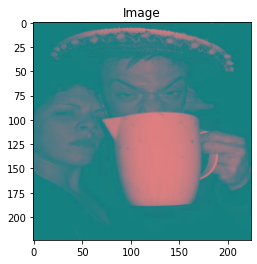

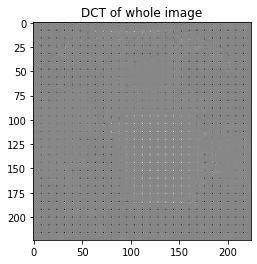

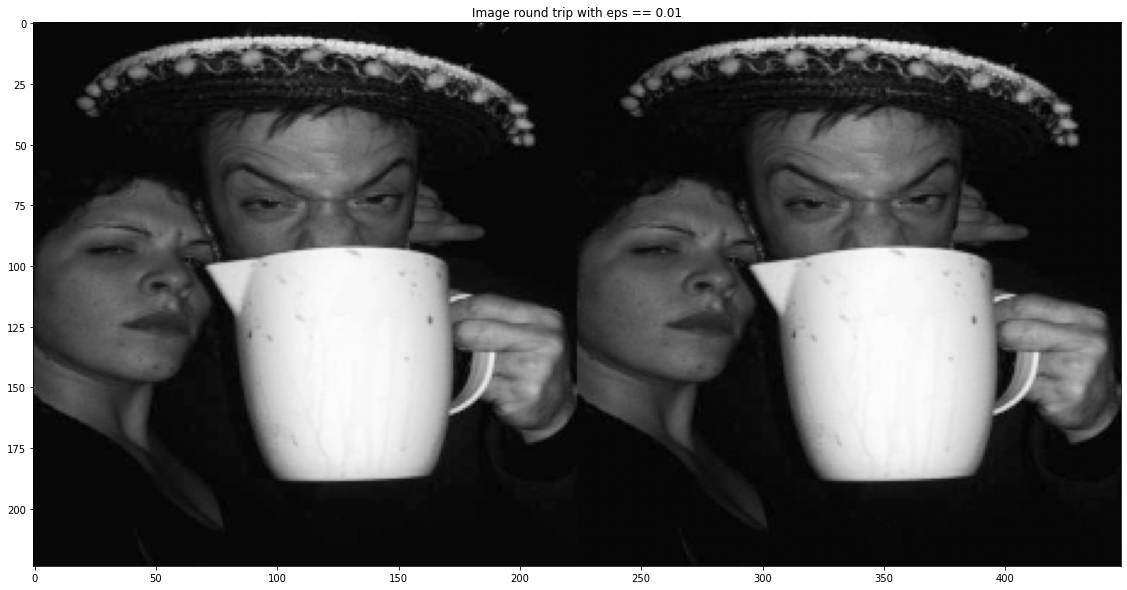

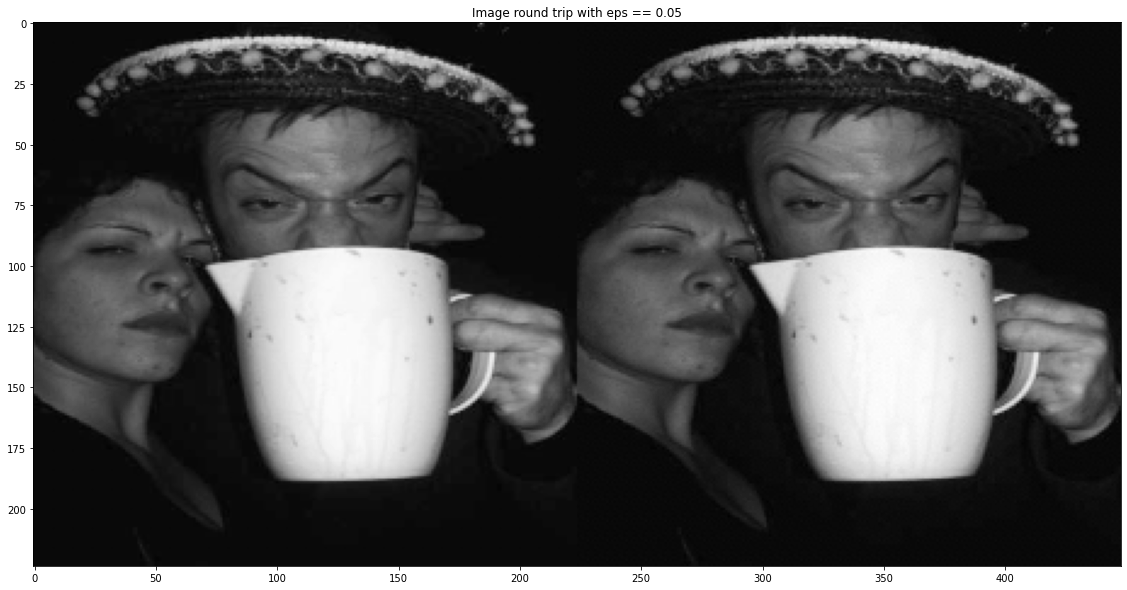

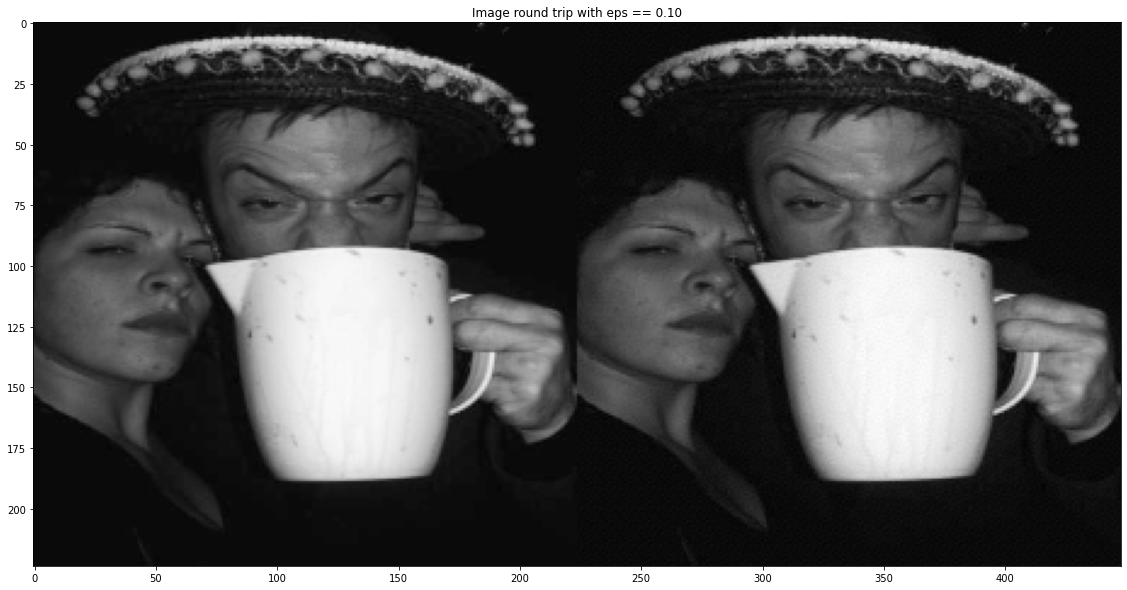

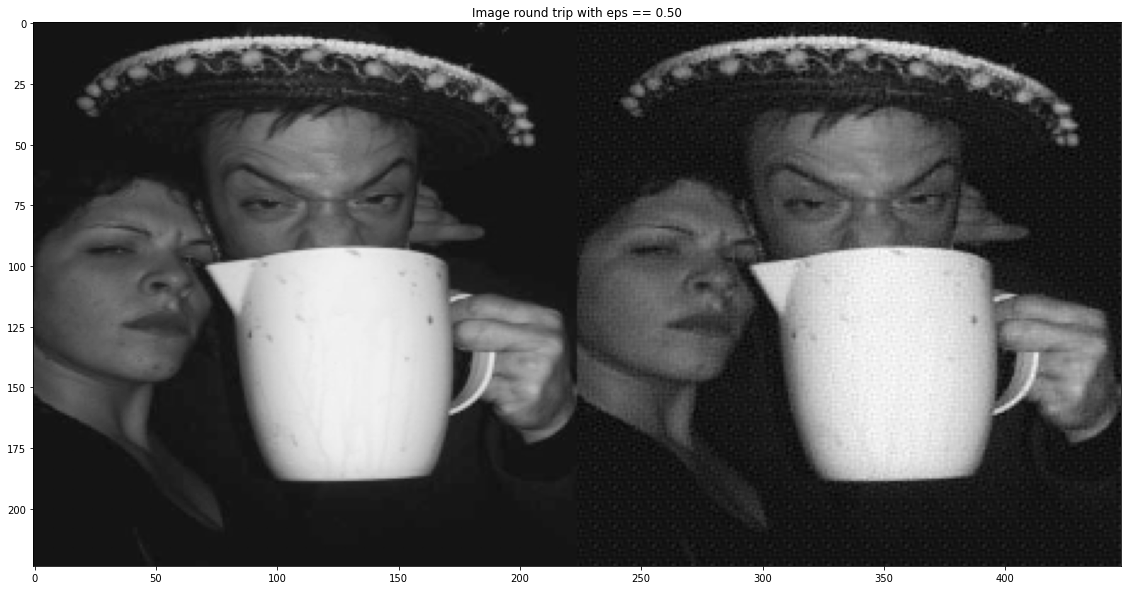

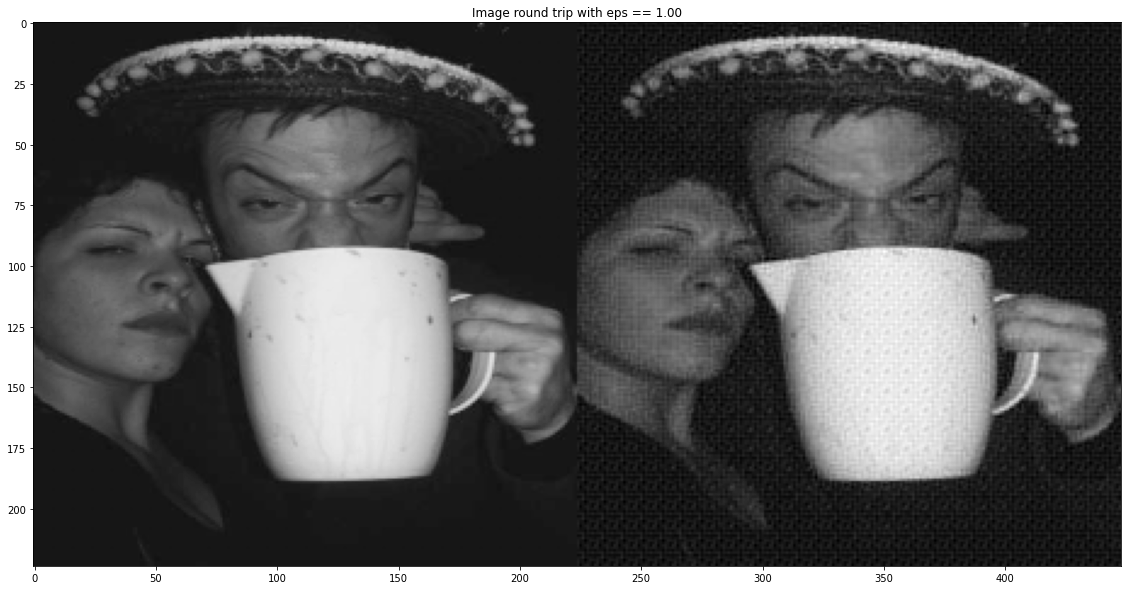

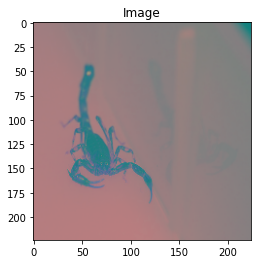

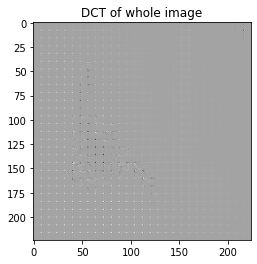

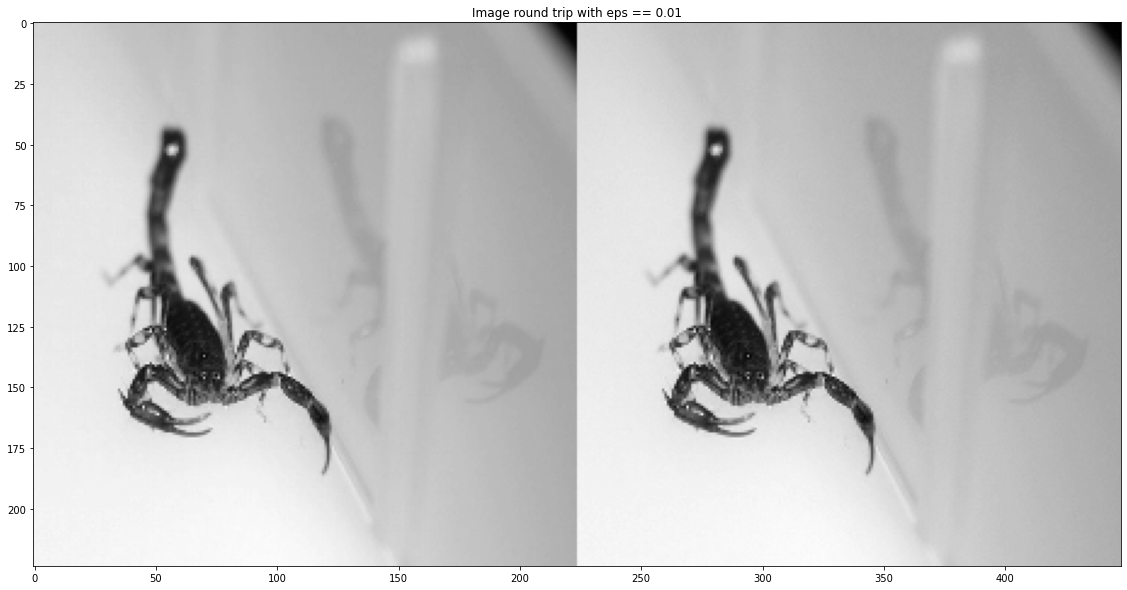

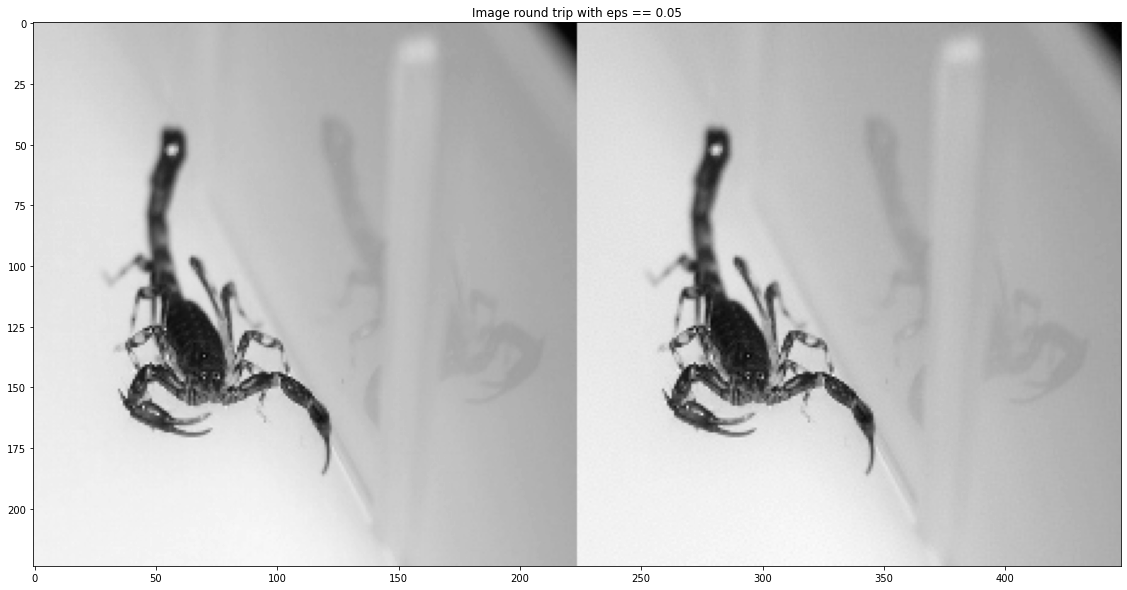

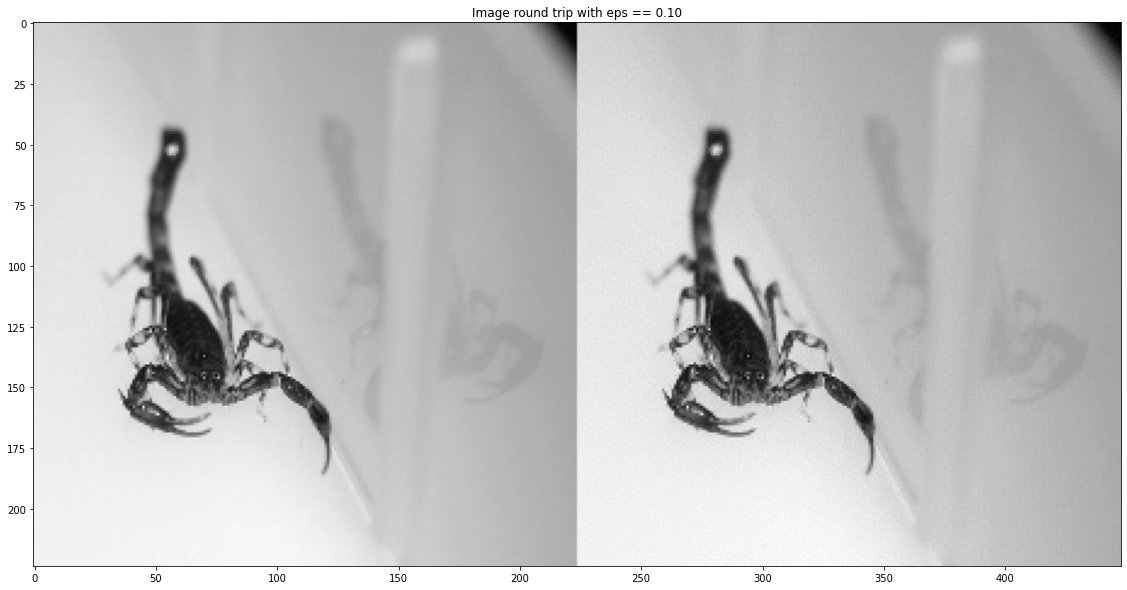

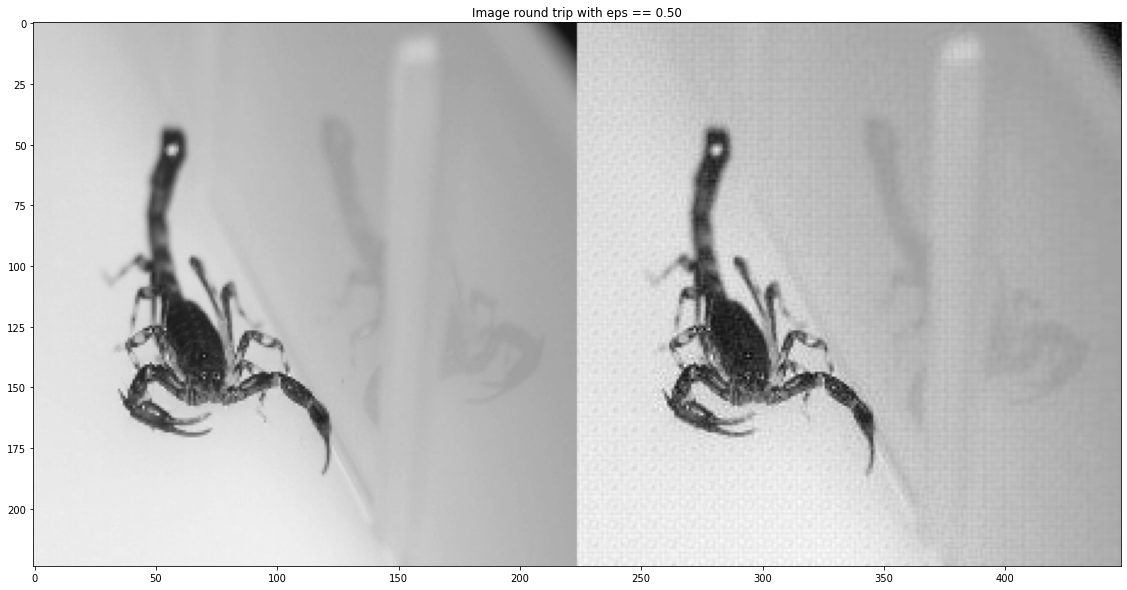

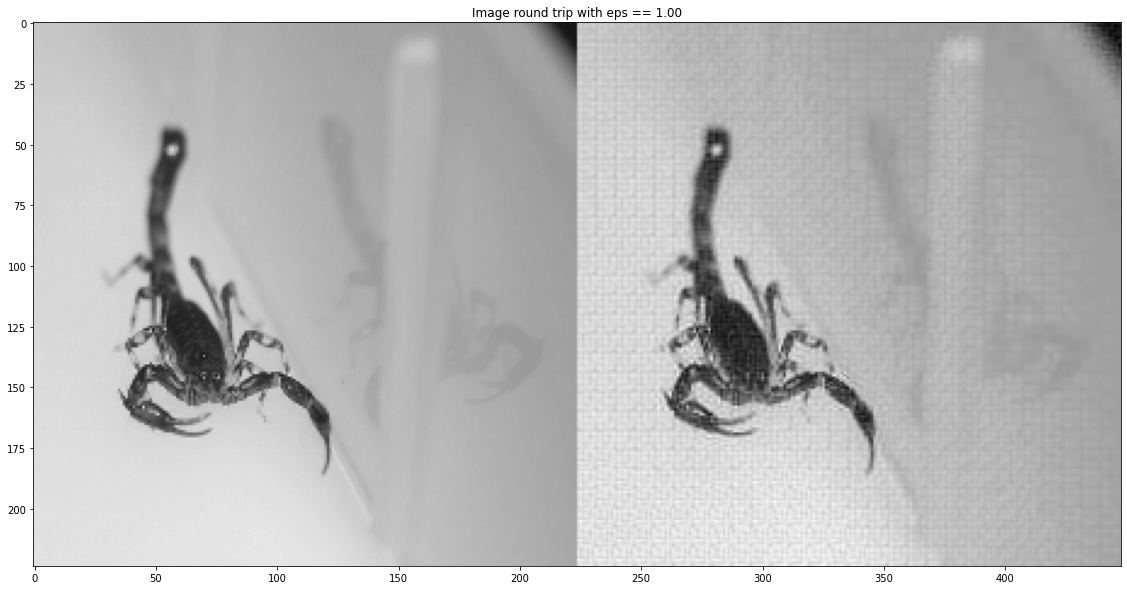

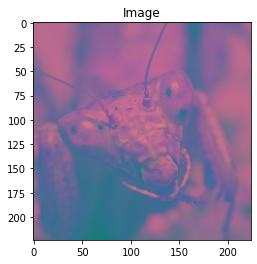

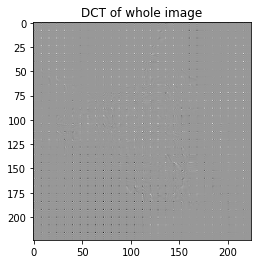

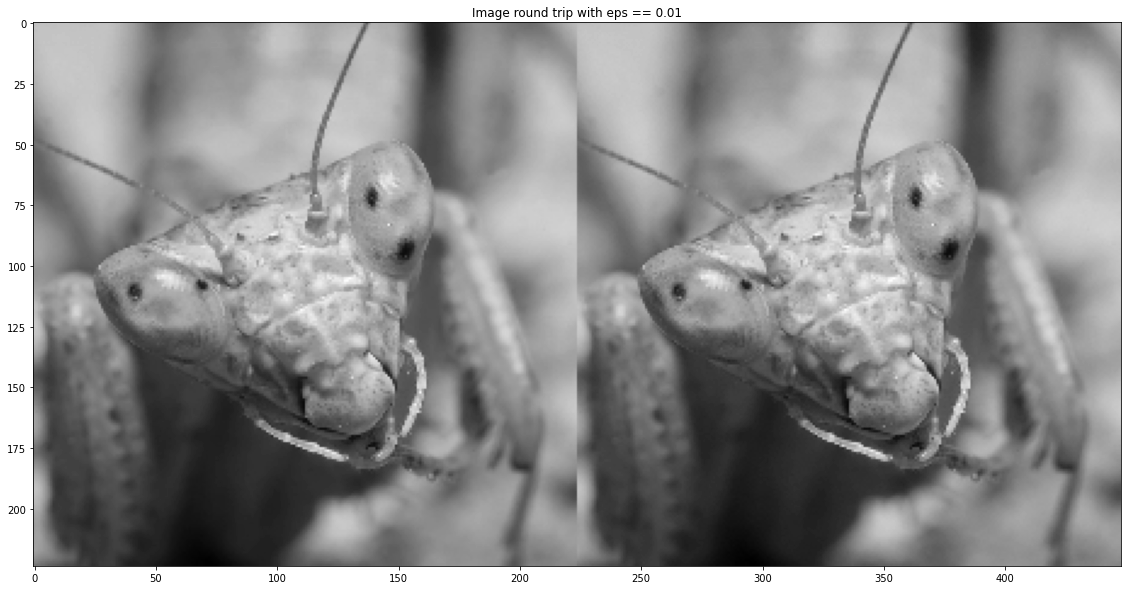

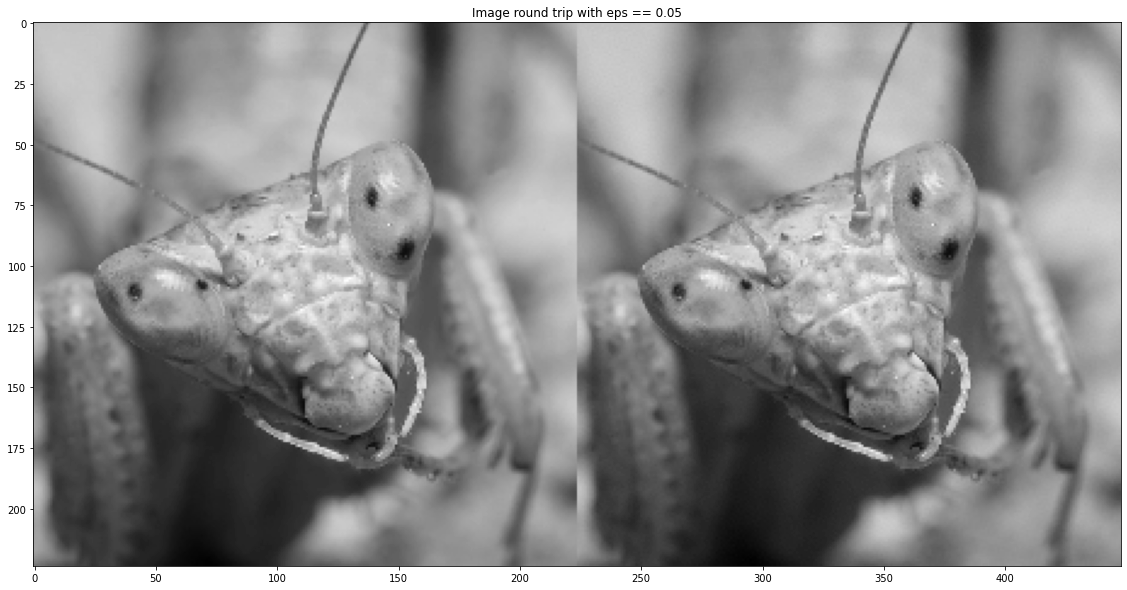

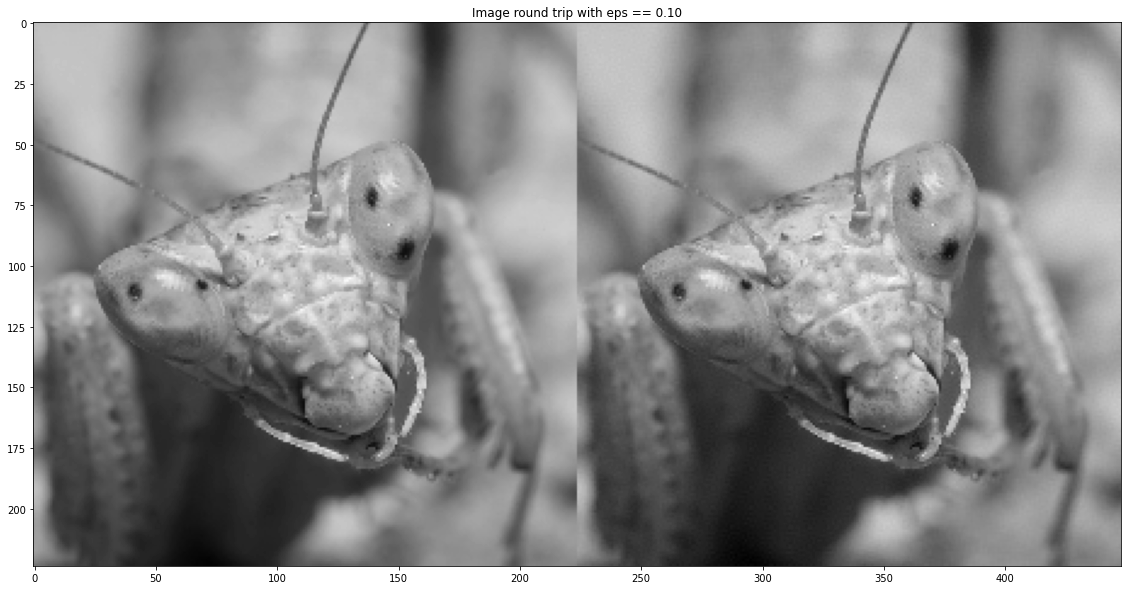

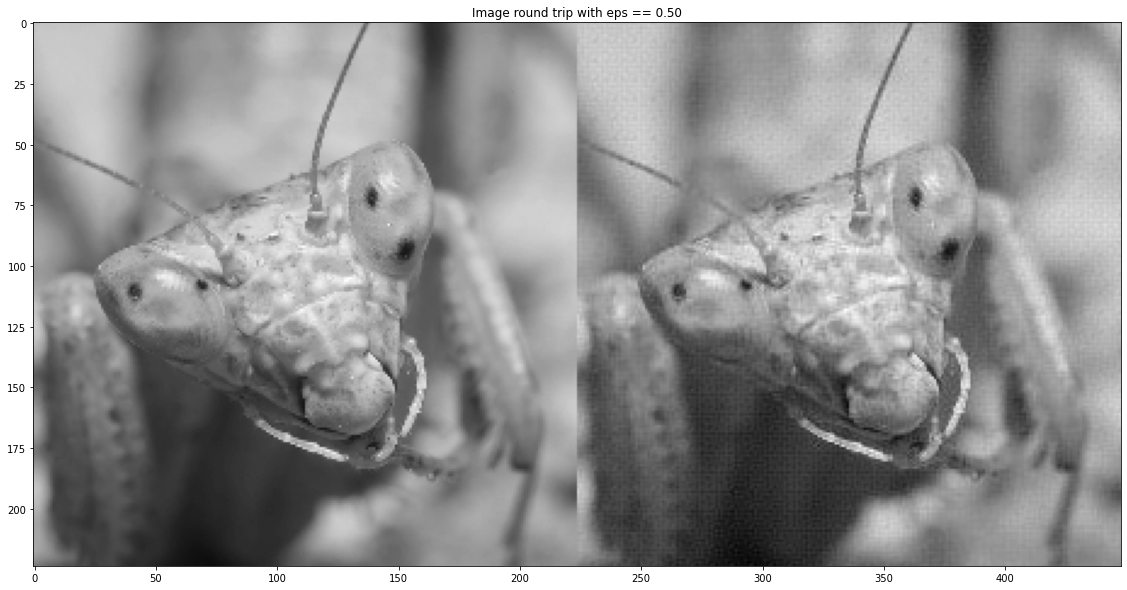

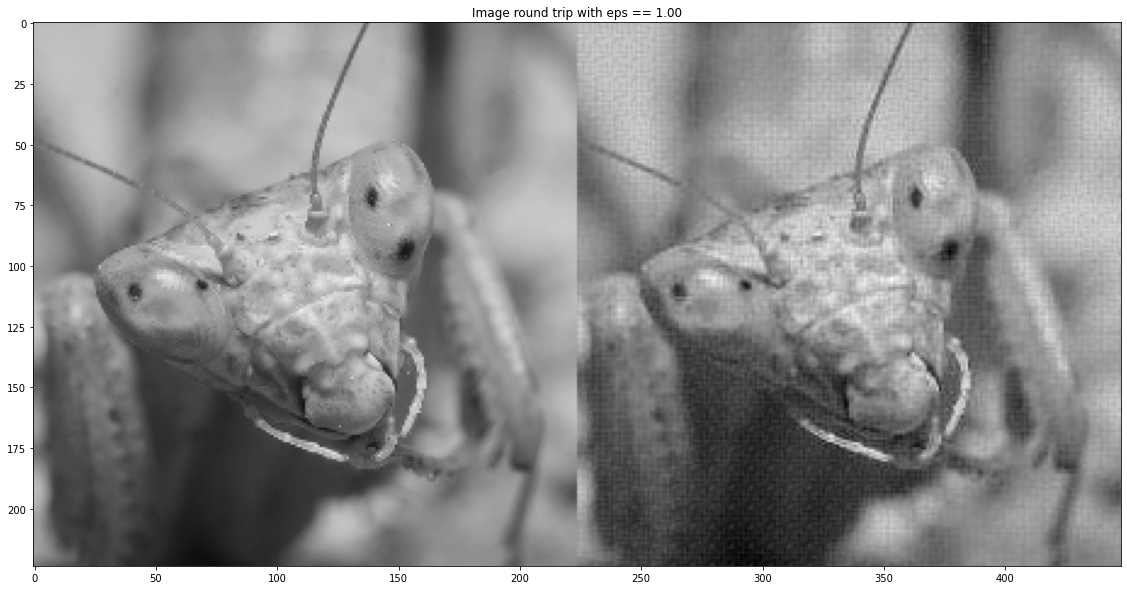

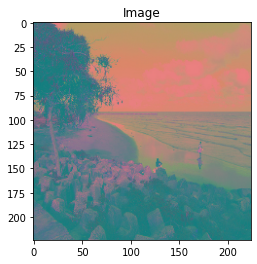

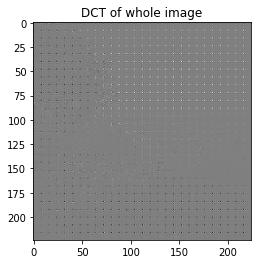

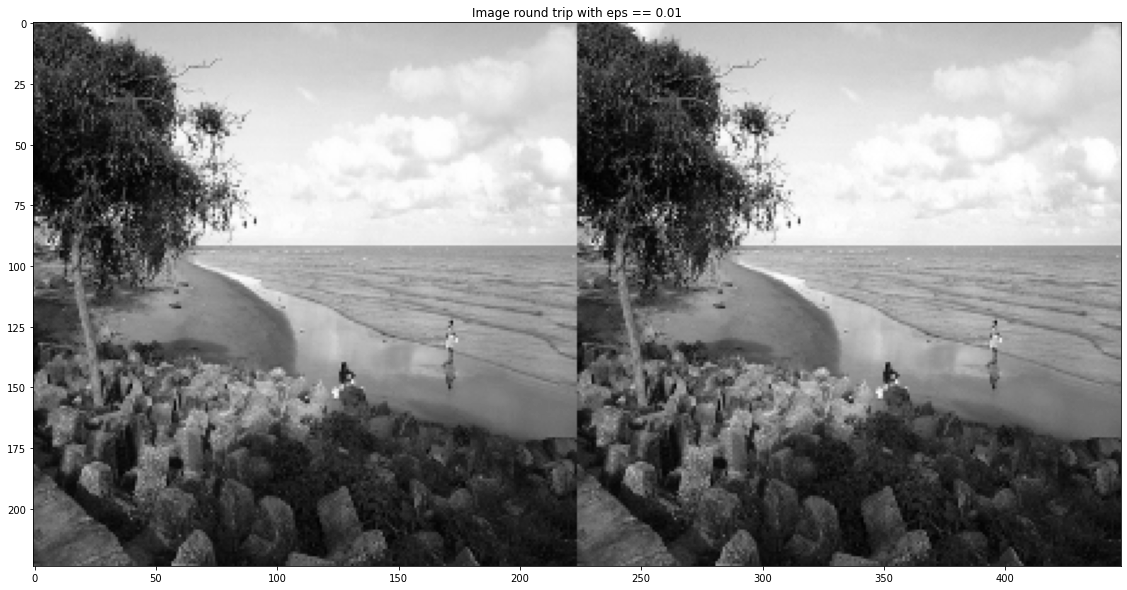

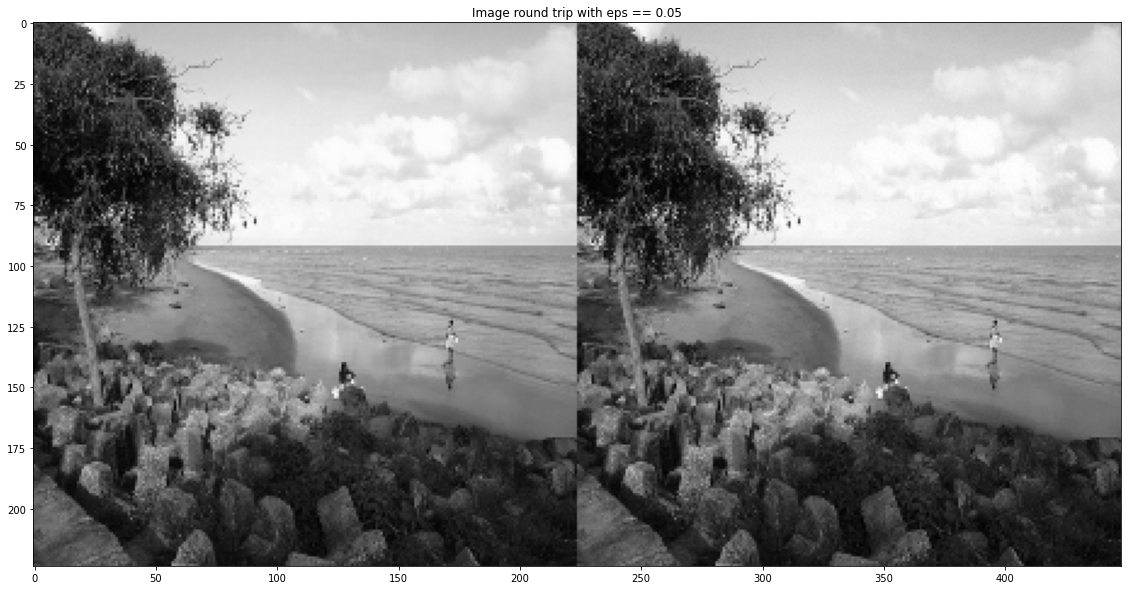

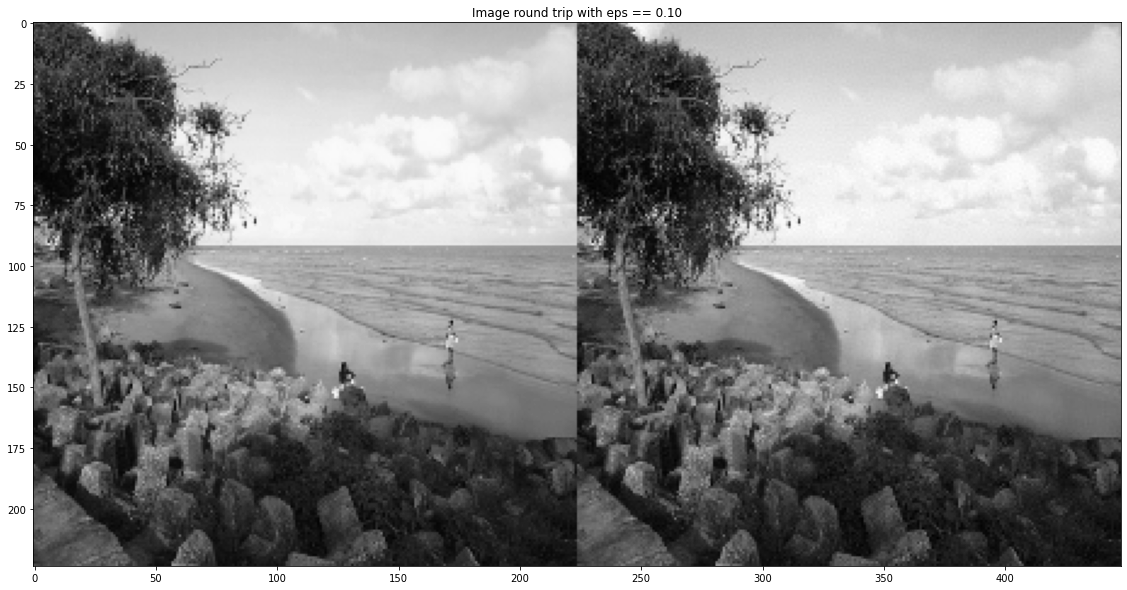

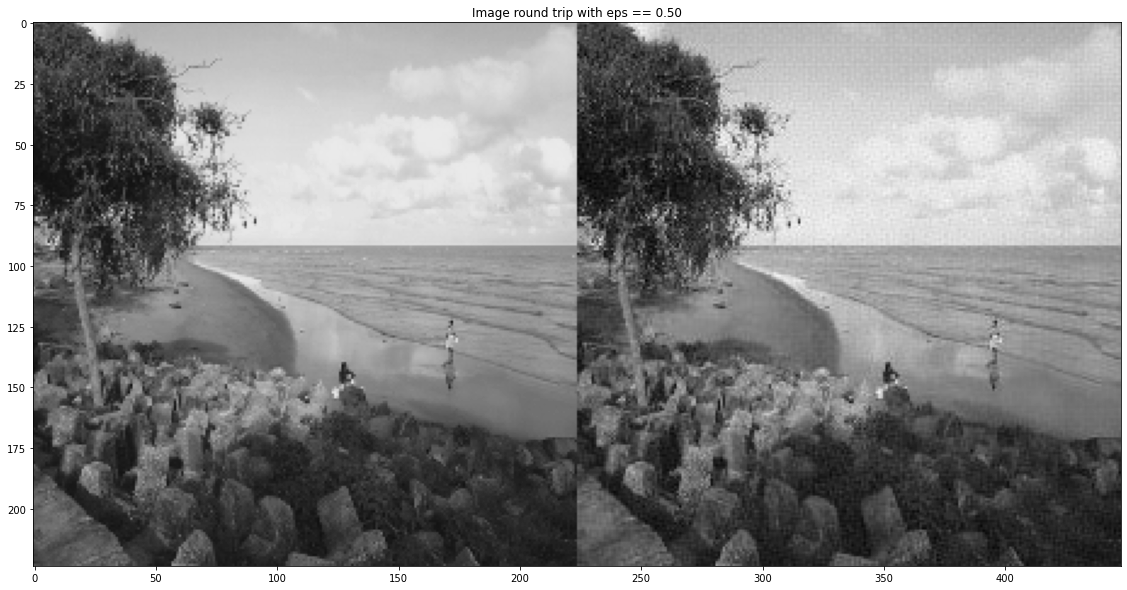

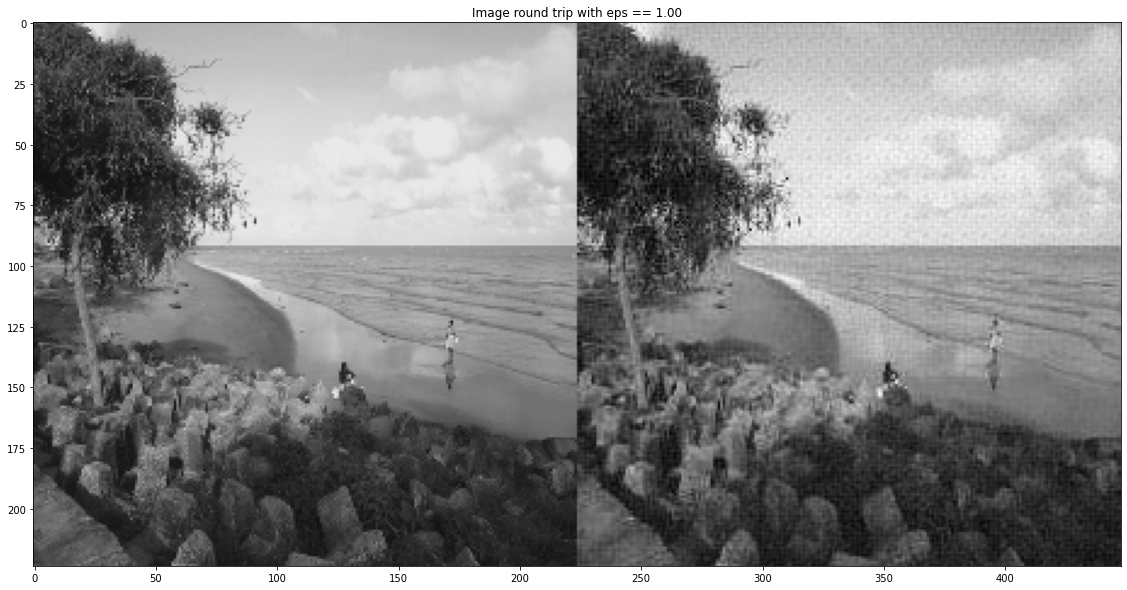

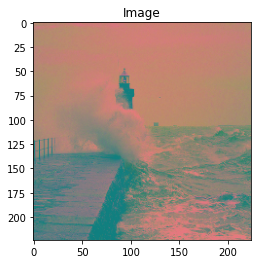

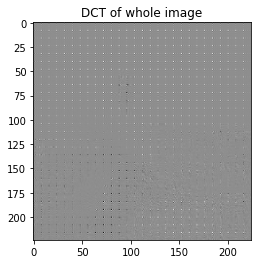

Error in callback <function flush_figures at 0x7fb863631f28> (for post_execute):


KeyboardInterrupt: ignored

In [23]:
# Get the input label of the images.
all_chroma_perturbations = []
all_freq_perturbations = []
for j,lbl in enumerate(imagenet_y):
  image = tf.expand_dims(imagenet_x[j], axis=0)

  image_probs = predict(image)
  label = tf.one_hot(lbl, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  if j == 0:
    all_labels = label
  else:
    all_labels = tf.concat([all_labels, label], 0)
  
  chroma_perturbations = create_chroma_adversarial_pattern(pretrained_model, image, label)
  freq_perturbations = create_freq_adversarial_pattern(pretrained_model, image, label)
  all_chroma_perturbations.append(chroma_perturbations)
  all_freq_perturbations.append(freq_perturbations)

#plt.figure(figsize=(10,10))
#imshow(all_freq_perturbations[0])
#plt.show()